## 환경설정 값 로딩

In [2]:
from dotenv import load_dotenv
import os

# .env 파일에서 환경 변수를 로드합니다.
load_dotenv()
PINECONE_API_KEY = os.environ['PINECONE_API_KEY']
# PINECONE_API_KEY

## Pinecone 클라이언트 초기화

In [3]:
from pinecone import Pinecone, ServerlessSpec

pc = Pinecone(api_key=PINECONE_API_KEY)

## 레코드 업서트(Upsert)

In [10]:
# embedding-3d라는 이름의 인덱스를 초기화
index = pc.Index("embedding-3d")

index.describe_index_stats()

{'dimension': 3,
 'index_fullness': 0.0,
 'namespaces': {'embedding-3d-ns1': {'vector_count': 6}},
 'total_vector_count': 6}

## index에 벡터 임베딩

In [17]:
# 벡터를 인덱스에 업서트(upsert)합니다.
# "embedding-3d-ns1" 네임스페이스에 벡터를 추가합니다.
index.upsert(
    vectors=[
        {
            "id": "vec1",
            "values": [1.0, 1.5, 2.0],  # 임베딩 벡터, 행벡터 3차원
            "metadata": {"genre": "drama"}  # 
        }, {
            "id": "vec2",
            "values": [2.0, 1.0, 0.5],
            "metadata": {"genre": "action"}
        }, {
            "id": "vec3",
            "values": [0.1, 0.3, 0.5],
            "metadata": {"genre": "drama"}
        }, {
            "id": "vec4",
            "values": [1.0, 2.5, 3.5],
            "metadata": {"genre": "action"}
        }, {
            "id": "vec5",
            "values": [3.0, 1.2, 1.3],
            "metadata": {"genre": "action"}
        }, {
            "id": "vec6",
            "values": [0.3, 1.1, 2.5],
            "metadata": {"genre": "drama"}
        }
    ],
    namespace="embedding-3d-ns1"  # namespace를 만들면 서칭 속도가 빨라짐 가능
)

{'upserted_count': 6}

In [18]:
index.describe_index_stats()

{'dimension': 3,
 'index_fullness': 0.0,
 'namespaces': {'embedding-3d-ns1': {'vector_count': 6}},
 'total_vector_count': 6}

## 쿼리하기

In [19]:
response = index.query(
    namespace="embedding-3d-ns1",
    vector=[0.1,0.3,0.7],
    top_k=3,
    include_values=True,
    include_metadata=True
)

In [20]:
print(response)

{'matches': [{'id': 'vec6',
              'metadata': {'genre': 'drama'},
              'score': 0.999730587,
              'values': [0.3, 1.1, 2.5]},
             {'id': 'vec3',
              'metadata': {'genre': 'drama'},
              'score': 0.990267396,
              'values': [0.1, 0.3, 0.5]},
             {'id': 'vec4',
              'metadata': {'genre': 'action'},
              'score': 0.972905517,
              'values': [1.0, 2.5, 3.5]}],
 'namespace': 'embedding-3d-ns1',
 'usage': {'read_units': 6}}


In [21]:
# genre가 drama 인것 안에서 찾기
response = index.query(
    namespace="embedding-3d-ns1",
    vector=[0.1,0.3,0.7],
    top_k=3,
    include_values=True,
    include_metadata=True,
    filter={
        "genre": {"$eq": "drama"}
    }
)
print(response)

{'matches': [{'id': 'vec6',
              'metadata': {'genre': 'drama'},
              'score': 0.999730587,
              'values': [0.3, 1.1, 2.5]},
             {'id': 'vec3',
              'metadata': {'genre': 'drama'},
              'score': 0.990267396,
              'values': [0.1, 0.3, 0.5]},
             {'id': 'vec1',
              'metadata': {'genre': 'drama'},
              'score': 0.942843497,
              'values': [1.0, 1.5, 2.0]}],
 'namespace': 'embedding-3d-ns1',
 'usage': {'read_units': 6}}


In [22]:
# embedding-3d-ns1 네임스페이스의 모든 레코드 id를 조회합니다.
for ids in index.list(namespace="embedding-3d-ns1"):
    print(ids)

['vec1', 'vec2', 'vec3', 'vec4', 'vec5', 'vec6']


In [23]:
# 지정된 네임스페이스(embedding-3d-ns1)에 있는 모든 ID를 리스트 형태로 반환합니다.
for ids in index.list(namespace="embedding-3d-ns1"):
    # 주어진 ID와 네임스페이스에 해당하는 벡터 데이터를 가져옵니다.
    # 반환된 데이터는 딕셔너리 형태이며, 그 중에서 'vectors' 키에 해당하는 값을 vectors 변수에 저장합니다.
    vectors = index.fetch(ids, namespace="embedding-3d-ns1")['vectors']

print(vectors.values())

dict_values([{'id': 'vec6', 'metadata': {'genre': 'drama'}, 'values': [0.3, 1.1, 2.5]}, {'id': 'vec4', 'metadata': {'genre': 'action'}, 'values': [1.0, 2.5, 3.5]}, {'id': 'vec2', 'metadata': {'genre': 'action'}, 'values': [2.0, 1.0, 0.5]}, {'id': 'vec1', 'metadata': {'genre': 'drama'}, 'values': [1.0, 1.5, 2.0]}, {'id': 'vec5', 'metadata': {'genre': 'action'}, 'values': [3.0, 1.2, 1.3]}, {'id': 'vec3', 'metadata': {'genre': 'drama'}, 'values': [0.1, 0.3, 0.5]}])


In [24]:
# ids: 벡터 데이터에서 추출한 ID 리스트.
# values: 벡터 데이터에서 추출한 값 리스트.
ids = [v['id'] for v in vectors.values()]
values = [v['values'] for v in vectors.values()]

ids += ["qv"]
values += [[0.1, 0.3, 0.7]]

print(ids)
print(values)

['vec6', 'vec4', 'vec2', 'vec1', 'vec5', 'vec3', 'qv']
[[0.3, 1.1, 2.5], [1.0, 2.5, 3.5], [2.0, 1.0, 0.5], [1.0, 1.5, 2.0], [3.0, 1.2, 1.3], [0.1, 0.3, 0.5], [0.1, 0.3, 0.7]]


## 3차원 공간에 표현에 시각화

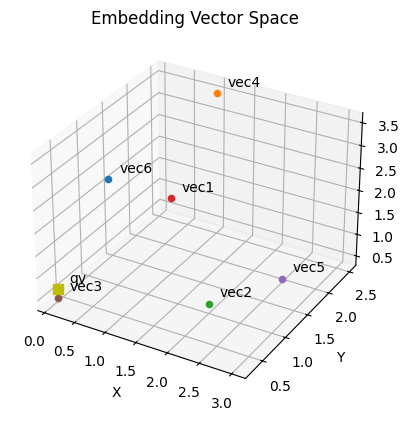

In [25]:
import matplotlib.pyplot as plt

# 3D 플롯을 생성합니다.
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# 각 벡터의 ID와 값을 사용하여 3D 공간에 점을 그립니다.
for i, id in enumerate(ids):
    if id == "qv":
        # 쿼리 벡터는 노란색 사각형으로 표시합니다.
        ax.scatter(values[i][0], values[i][1], values[i][2], label=id, color='y', s=50, marker='s')
        ax.text(values[i][0] + 0.1, values[i][1] + 0.1, values[i][2] + 0.1, id)
    else:
        # 나머지 벡터는 기본 색상으로 표시합니다.
        ax.scatter(values[i][0], values[i][1], values[i][2], label=id)
        ax.text(values[i][0] + 0.1, values[i][1] + 0.1, values[i][2] + 0.1, id)

# 축 레이블과 제목을 설정합니다.
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('Embedding Vector Space')

# 플롯을 표시합니다.
plt.show()

## 인덱스 생성과 삭제

In [4]:
## embedding vector DB index 삭제
index_name = "quickstart"

# Pinecone에 있는 모든 인덱스를 순회합니다.
for idx in pc.list_indexes():
    # 인덱스 이름이 "quickstart"와 일치하는 경우 해당 인덱스를 삭제합니다.
    if idx.name == index_name:
        pc.delete_index(idx.name)

In [5]:
# Pinecone 인덱스를 생성합니다.
# 인덱스 이름은 "quickstart"이고, 차원은 1024, 메트릭은 코사인 유사도를 사용합니다.
# 인덱스는 AWS의 us-east-1 리전에서 서버리스 사양으로 생성됩니다.
index_name = "quickstart"
pc.create_index(
    name=index_name,
    dimension=1024,  # 모델 차원
    metric="cosine",  # 모델 메트릭
    spec=ServerlessSpec(
        cloud="aws",
        region="us-east-1"
    )
)

In [50]:
# pinecone 클라이언트를 사용하여 현재 사용 가능한 인덱스의 목록 반환
pc.list_indexes()

{'indexes': [{'deletion_protection': 'disabled',
              'dimension': 1024,
              'host': 'quickstart-9wtgah8.svc.aped-4627-b74a.pinecone.io',
              'metric': 'cosine',
              'name': 'quickstart',
              'spec': {'serverless': {'cloud': 'aws', 'region': 'us-east-1'}},
              'status': {'ready': True, 'state': 'Ready'}},
             {'deletion_protection': 'disabled',
              'dimension': 3,
              'host': 'embedding-3d-9wtgah8.svc.aped-4627-b74a.pinecone.io',
              'metric': 'cosine',
              'name': 'embedding-3d',
              'spec': {'serverless': {'cloud': 'aws', 'region': 'us-east-1'}},
              'status': {'ready': True, 'state': 'Ready'}},
             {'deletion_protection': 'disabled',
              'dimension': 1536,
              'host': 'wine-sommelie-9wtgah8.svc.aped-4627-b74a.pinecone.io',
              'metric': 'cosine',
              'name': 'wine-sommelie',
              'spec': {'serverless

## embedding vector 생성

In [51]:
# Embed data
data = [
    {"id": "vec1", "text": "사과는 달콤하고 아삭한 식감으로 유명한 인기 있는 과일입니다."},
    {"id": "vec2", "text": "애플이라는 기술 회사는 아이폰과 같은 혁신적인 제품으로 유명합니다."},
    {"id": "vec3", "text": "많은 사람들이 건강한 간식으로 사과를 즐겨 먹습니다."},
    {"id": "vec4", "text": "애플 주식회사는 세련된 디자인과 사용자 친화적인 인터페이스로 기술 산업을 혁신했습니다."},
    {"id": "vec5", "text": "하루에 사과 하나면 의사를 멀리할 수 있다는 속담이 있습니다."},
    {"id": "vec6", "text": "애플 컴퓨터 회사는 1976년 4월 1일 스티브 잡스, 스티브 워즈니악, 로널드 웨인에 의해 파트너십으로 설립되었습니다."}
]

embeddings = pc.inference.embed(
    model="multilingual-e5-large",
    inputs=[d['text'] for d in data],
    parameters={
        "input_type": "passage"
    }
)

print(embeddings[0])

{'values': [0.0303497314453125, -0.02069091796875, ..., -0.0301971435546875, 0.0240325927734375]}


In [57]:

# print(embeddings.data[0])
# print(embeddings[0]['values'])
print(len(embeddings[0]['values']))

1024


## 파인콘에 upsert하기 위한 준비

In [58]:
import time

# 인덱스가 준비될 때까지 대기합니다.
while not pc.describe_index(index_name).status['ready']:
    time.sleep(1)

# 인덱스를 초기화합니다.
index_name = "quickstart"
index = pc.Index(index_name)

In [59]:
# pinecorn에 upsert하기 위한 데이터 구성
vectors = []
for d, e in zip(data, embeddings):
    vectors.append({
        "id": d['id'],
        "values": e['values'],
        "metadata": {'text': d['text']}
    })

vectors

[{'id': 'vec1',
  'values': [0.0303497314453125,
   -0.02069091796875,
   0.00838470458984375,
   -0.03240966796875,
   0.03179931640625,
   -0.041107177734375,
   0.00112152099609375,
   0.07366943359375,
   0.0264892578125,
   -0.0279693603515625,
   0.057647705078125,
   0.00455474853515625,
   -0.0255889892578125,
   0.00762939453125,
   -0.00551605224609375,
   -0.005401611328125,
   -0.04522705078125,
   -0.0017881393432617188,
   -0.0052490234375,
   -0.0073699951171875,
   0.01361846923828125,
   -0.0006814002990722656,
   -0.05108642578125,
   0.0051727294921875,
   -0.007747650146484375,
   -0.01398468017578125,
   -0.027313232421875,
   -0.02783203125,
   -0.0255889892578125,
   -0.04449462890625,
   -0.0250701904296875,
   -0.00370025634765625,
   -0.02996826171875,
   -0.0638427734375,
   -0.006134033203125,
   0.0419921875,
   0.0168609619140625,
   0.017242431640625,
   -0.023773193359375,
   0.0099029541015625,
   -0.0220947265625,
   0.061859130859375,
   -0.0119247436

In [60]:
# uickstart_ns1 namespace에 데이터 업로딩
index.upsert(
    vectors=vectors,
    namespace="quickstart_ns1"  # 입력 namespace
)

{'upserted_count': 6}

In [61]:
# namespace 값 전달하기
# print(index.describe_index_stats())
print(index.describe_index_stats(namespace="quickstart_ns1"))

{'dimension': 1024,
 'index_fullness': 0.0,
 'namespaces': {'quickstart_ns1': {'vector_count': 6},
                'uickstart_ns1': {'vector_count': 6}},
 'total_vector_count': 12}


## 쿼리(Query) 1
- 사용자 질문을 받아서, embedding vector로 생성하기

### 쿼리 벡터 생성

In [28]:
# 쿼리 텍스트를 정의합니다.
query = "애플이라는 기술 회사에 대해 알려주세요."

In [44]:
# 쿼리 텍스트를 임베딩 벡터로 변환합니다.
embedding = pc.inference.embed(
    model="multilingual-e5-large",  # ms 오픈 소스, 1024 차원
    inputs=[query],
    parameters={
        "input_type": "query"  # 입력 타입을 쿼리로 설정합니다.
    }
)

# 첫 번째 임베딩 벡터를 출력합니다.
print(embedding)
print("="*30)
# embedding[0], embedding.data[0] 두 표현은 결과가 동일하게 나옴
print(embedding[0])
print(embedding.data[0])
print("="*30)
print(len(embedding[0]['values']))

EmbeddingsList(
  model='multilingual-e5-large',
  data=[
    {'values': [0.01128387451171875, -0.017608642578125, ..., -0.02032470703125, -0.006984710693359375]}
  ],
  usage={'total_tokens': 14}
)
{'values': [0.01128387451171875, -0.017608642578125, ..., -0.02032470703125, -0.006984710693359375]}
{'values': [0.01128387451171875, -0.017608642578125, ..., -0.02032470703125, -0.006984710693359375]}
1024


### 유사 벡터 검색을 위한 쿼리 실행

In [45]:
# quickstart_ns1 네임스페이스에서 쿼리 벡터와 유사한 상위 3개의 벡터를 검색합니다.
# 검색 결과에는 벡터 값은 포함되지 않고 메타데이터만 포함됩니다.
results = index.query(
    namespace="quickstart_ns1",
    vector=embedding[0].values,  # query 벡터
    top_k=3,
    include_values=False,   # value는 제외
    include_metadata=True
)

# 검색 결과를 출력합니다.
print(results)

{'matches': [{'id': 'vec2',
              'metadata': {'text': '애플이라는 기술 회사는 아이폰과 같은 혁신적인 제품으로 유명합니다.'},
              'score': 0.895539701,
              'values': []},
             {'id': 'vec4',
              'metadata': {'text': '애플 주식회사는 세련된 디자인과 사용자 친화적인 인터페이스로 기술 산업을 '
                                   '혁신했습니다.'},
              'score': 0.882827282,
              'values': []},
             {'id': 'vec6',
              'metadata': {'text': '애플 컴퓨터 회사는 1976년 4월 1일 스티브 잡스, 스티브 워즈니악, '
                                   '로널드 웨인에 의해 파트너십으로 설립되었습니다.'},
              'score': 0.867309868,
              'values': []}],
 'namespace': 'quickstart_ns1',
 'usage': {'read_units': 6}}


## 쿼리(Query) 2

In [46]:
# 쿼리 텍스트를 정의합니다.
query = "사과라는 기술 회사에 대해 알려주세요."

# 쿼리 텍스트를 임베딩 벡터로 변환합니다.
embedding = pc.inference.embed(
    model="multilingual-e5-large",
    inputs=[query],
    parameters={
        "input_type": "query"  # 입력 타입을 쿼리로 설정합니다.
    }
)

# 첫 번째 임베딩 벡터를 출력합니다.
print(embedding[0])

{'values': [-0.0159454345703125, -0.0099029541015625, ..., -0.037139892578125, 0.01248931884765625]}


In [47]:
# ns1 네임스페이스에서 쿼리 벡터와 유사한 상위 3개의 벡터를 검색합니다.
# 검색 결과에는 벡터 값은 포함되지 않고 메타데이터만 포함됩니다.
results = index.query(
    namespace="quickstart_ns1",
    vector=embedding[0].values,  # query 벡터
    top_k=3,
    include_values=False,   # value는 제외
    include_metadata=True
)

# 검색 결과를 출력합니다.
print(results)

{'matches': [{'id': 'vec2',
              'metadata': {'text': '애플이라는 기술 회사는 아이폰과 같은 혁신적인 제품으로 유명합니다.'},
              'score': 0.829680085,
              'values': []},
             {'id': 'vec5',
              'metadata': {'text': '하루에 사과 하나면 의사를 멀리할 수 있다는 속담이 있습니다.'},
              'score': 0.82154882,
              'values': []},
             {'id': 'vec1',
              'metadata': {'text': '사과는 달콤하고 아삭한 식감으로 유명한 인기 있는 과일입니다.'},
              'score': 0.820473,
              'values': []}],
 'namespace': 'quickstart_ns1',
 'usage': {'read_units': 6}}


## 쿼리(Query) 3

### 질문 인코딩(embedding vector로 변환)

In [62]:
# 쿼리 텍스트를 정의합니다.
query = "애플(사과)라는 기술 회사에 대해 알려주세요."

# 쿼리 텍스트를 임베딩 벡터로 변환합니다.
embedding = pc.inference.embed(
    model="multilingual-e5-large",  
    inputs=[query],
    parameters={
        "input_type": "query"  # 입력 타입을 쿼리로 설정합니다.
    }
)

# 첫 번째 임베딩 벡터를 출력합니다.
print(embedding[0])

{'values': [-0.00437164306640625, -0.021728515625, ..., -0.01873779296875, 0.00787353515625]}


### 유사도 높은 top 3 검색 실행

In [63]:
# ns1 네임스페이스에서 쿼리 벡터와 유사한 상위 3개의 벡터를 검색합니다.
# 검색 결과에는 벡터 값은 포함되지 않고 메타데이터만 포함됩니다.
results = index.query(
    namespace="quickstart_ns1",
    vector=embedding[0].values,  # query 벡터
    top_k=3,
    include_values=False,   # value는 제외
    include_metadata=True
)

# 검색 결과를 출력합니다.
print(results)

{'matches': [{'id': 'vec2',
              'metadata': {'text': '애플이라는 기술 회사는 아이폰과 같은 혁신적인 제품으로 유명합니다.'},
              'score': 0.881810725,
              'values': []},
             {'id': 'vec4',
              'metadata': {'text': '애플 주식회사는 세련된 디자인과 사용자 친화적인 인터페이스로 기술 산업을 '
                                   '혁신했습니다.'},
              'score': 0.871935964,
              'values': []},
             {'id': 'vec6',
              'metadata': {'text': '애플 컴퓨터 회사는 1976년 4월 1일 스티브 잡스, 스티브 워즈니악, '
                                   '로널드 웨인에 의해 파트너십으로 설립되었습니다.'},
              'score': 0.8551175,
              'values': []}],
 'namespace': 'quickstart_ns1',
 'usage': {'read_units': 6}}
